Quick check if alternative plots of the BV trends would be better

1. Faceted Historgram
2. Facet high and low lines


In [4]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.figures import *
from src.utils import get_project_root, format_table
from src.swinno_helpers import connect_swinno_db

ROOT = get_project_root()
conn = connect_swinno_db()

# set all text on plots to be monospace with rcParams
plt.rcParams["font.family"] = "Space Grotesk"

sns.set_theme(style="white")

# full code labels for merging
codes_df = pd.read_sql("SELECT * FROM classification_codes", conn)

codes_df["Category"] = codes_df["Category"].str.strip()
uncertain_eco = {"Code": ["000"], "Category": ["Unsure"]}
codes_df = pd.concat([codes_df, pd.DataFrame(uncertain_eco)], ignore_index=True)

codes_df = codes_df[~codes_df["Code"].duplicated(keep="last")]

codes_df = codes_df.set_index("Code")

In [5]:
bioeconomy = pd.read_sql(
    """ 
    SELECT distinct sinno_id from (SELECT
    i.sinno_id,
    i.innovation_name_in_swedish AS name,
    i.literal_name_of_innovating_firm_sinnos_common_name_sinno_id AS firm,
    i.literal_name_of_collaborator_sinnos_common_name_sinno_id AS collaborator_0,
    i.literal_name_of_collaborator_sinnos_common_name_sinno_id1 AS collaborator_1,
    i.literal_name_of_collaborator_sinnos_common_name_sinno_id2 AS collaborator_2,
    i.literal_name_of_collaborator_sinnos_common_name_sinno_id3 AS collaborator_3,
    i.literal_name_of_collaborator_sinnos_common_name_sinno_id4 AS collaborator_4,
    i.literal_name_of_collaborator_sinnos_common_name_sinno_id5 AS collaborator_5,
    i.literal_name_of_collaborator_sinnos_common_name_sinno_id6 AS collaborator_6,
    i.literal_name_of_collaborator_sinnos_common_name_sinno_id7 AS collaborator_7,
    i.literal_name_of_collaborator_sinnos_common_name_sinno_id8 AS collaborator_8,
    i.description_in_swedish AS description,
    i.year_of_commercialization AS year,
    us.use_sector
    FROM
    innovation i
    JOIN use_sectors us ON i.sinno_id = us.sinno_id
    WHERE
    (
        us.use_sector LIKE '02%'
        OR us.use_sector LIKE '20%'
        OR us.use_sector LIKE '21%'
        OR us.use_sector LIKE '36%'
        OR product_code LIKE '02%'
        OR product_code LIKE '20%'
        OR product_code LIKE '21%'
        OR product_code LIKE '36%'
    )
    OR (
        description LIKE '%virke%'
        OR description LIKE '%cellulos%'
        OR description LIKE '%lignin%'
        OR description LIKE '%spån%'
        OR description LIKE '%bark%'
        OR description LIKE '%levulinsyra%'
        OR description LIKE '%furfural%'
        OR description LIKE '%svarttjära%'
        OR description LIKE '%svartlut%'
        OR description LIKE '%växtbas%'
        OR description LIKE '%ved%'
        OR description LIKE '%trä%'
        OR description LIKE '%skog%'
        OR description LIKE '%biobränsle%'
        OR description LIKE '%biologisk%'
        OR description LIKE '%nedbrytbar%'
        OR description LIKE '%papper%'
        OR description LIKE '%pappret%'
        OR description LIKE '%karton%'
        OR description LIKE '%tencel%'
    )
    AND i.sinno_id not in (select sinno_id from categorization_notes
    where notes not like "%not forest%"));
""",
    conn,
)

sni_codes = pd.read_sql_query(
    """
select
*
from 
sni_codes
""",
    conn,
)

sni_codes = sni_codes.rename(columns={"code": "use_sector"})

swinno = pd.read_sql_query(
    """
select sinno_id, year_of_commercialization as year, innovation_name_in_swedish as name
from innovation;
""",
    conn,
)

swinno["bioeconomy"] = swinno["sinno_id"].isin(bioeconomy["sinno_id"].unique())

In [6]:
bioeconomy_visions = pd.read_sql(
    """
SELECT bv.sinno_id
, codes.Category AS bioeconomy_vision
, i.year_of_commercialization AS "year"
FROM bioeconomy_visions AS bv
JOIN [classification_codes] AS codes ON codes.code = bv.bioeconomy_vision
JOIN innovation AS i ON i.sinno_id = bv.sinno_id
WHERE bv.sinno_id NOT IN (SELECT sinno_id FROM categorization_notes WHERE notes NOT LIKE "%not forest%")
UNION
SELECT DISTINCT(ei.sinno_id)
, 'Bioecology Vision' AS bioeconomy_vision
, i.year_of_commercialization AS "i.year"
FROM eco_innovations AS ei
JOIN innovation AS i ON i.sinno_id = ei.sinno_id
WHERE ei.innovation_type IN (206, 107)
AND ei.sinno_id NOT IN (
  SELECT ei2.sinno_id
  FROM eco_innovations as ei2
  WHERE ei2.innovation_type IN (999, '000')
  );
-- adds recycling innovation to bioecology
""",
    conn,
)

bioeconomy_visions.loc[
    bioeconomy_visions["bioeconomy_vision"] == "Not Bioeconomy",
    ["bioeconomy_vision"],
] = "Vision Neutral"

uncertain_bioeconomy_visions = bioeconomy_visions.query("bioeconomy_vision == 'Unsure'")


certain_bioeconomy_visions = bioeconomy_visions.loc[
    ~bioeconomy_visions["sinno_id"].isin(uncertain_bioeconomy_visions["sinno_id"]), :
]

count_certain_bioeconomy_visions = (
    certain_bioeconomy_visions.groupby(["year", "bioeconomy_vision"])
    .size()
    .reset_index(name="count")
)

total_certain_bioeconomy_visions = (
    count_certain_bioeconomy_visions.groupby("bioeconomy_vision")
    .agg("sum", numeric_only=True)
    .sort_values("count", ascending=False)
    .reset_index()
)

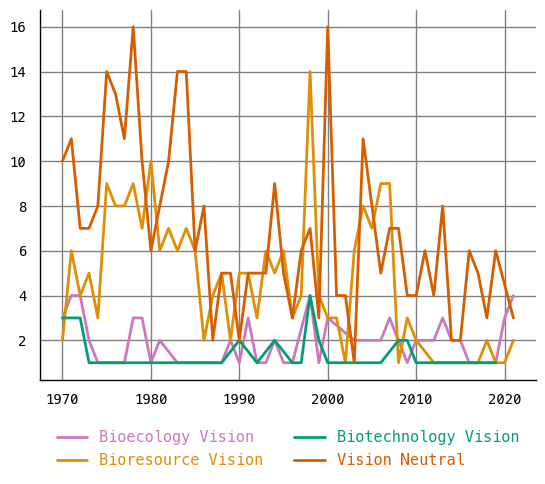

In [7]:
import matplotlib as mpl

# Define a new theme
new_theme = {
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.grid": True,
    "axes.axisbelow": True,
    "axes.labelcolor": "black",
    "axes.linewidth": 1.0,
    "grid.color": "gray",
    "grid.linestyle": "-",
    "xtick.color": "black",
    "xtick.direction": "out",
    "ytick.color": "black",
    "ytick.direction": "out",
    "lines.linewidth": 2.0,
    "lines.solid_capstyle": "round",
    "font.family": "Menlo",
}

# Update the matplotlib configuration parameters
mpl.rcParams.update(new_theme)

plot_bv_trends(count_certain_bioeconomy_visions)

In [6]:
count_certain_bioeconomy_visions.head()

,year,bioeconomy_vision,count
0,1970,Bioecology Vision,3
1,1970,Bioresource Vision,2
2,1970,Biotechnology Vision,3
3,1970,Vision Neutral,10
4,1971,Bioecology Vision,4


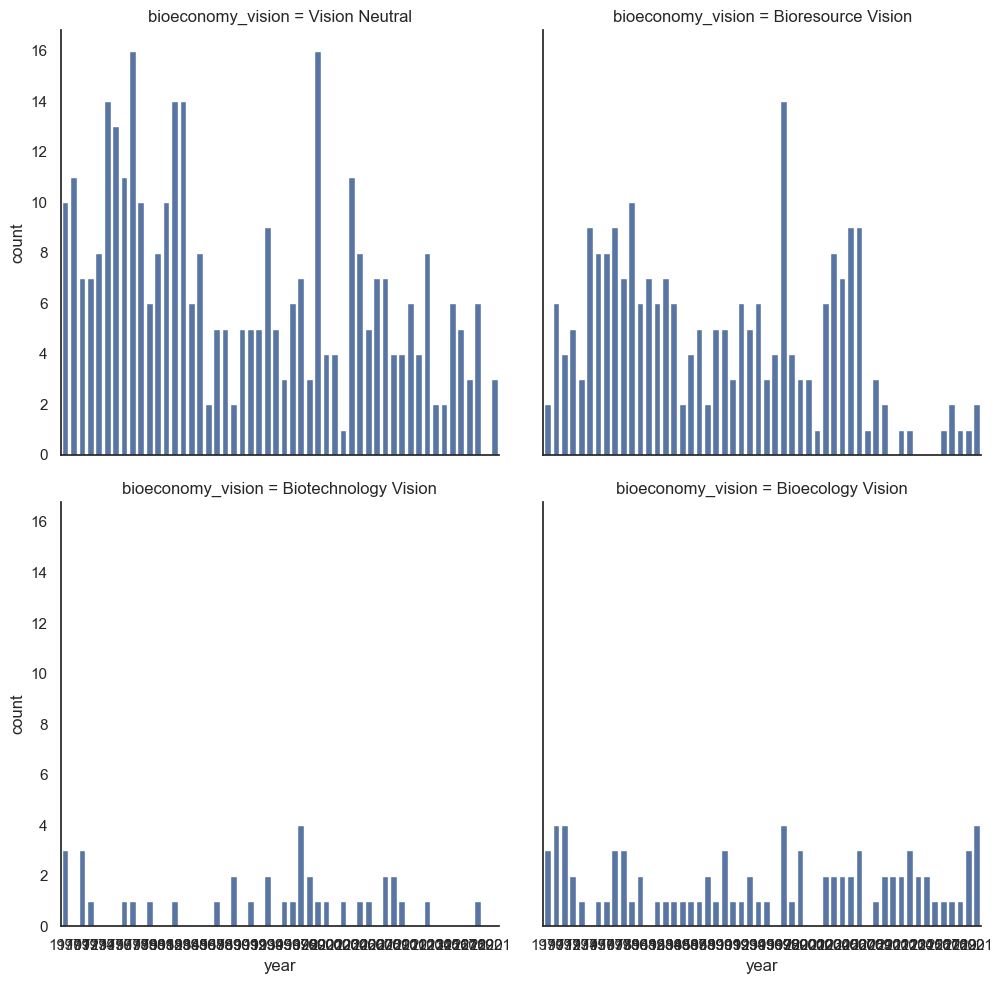

In [12]:
sns.catplot(
    x="year",
    y="count",
    col="bioeconomy_vision",
    kind="bar",
    data=count_certain_bioeconomy_visions,
    col_wrap=2,
    col_order=[
        "Vision Neutral",
        "Bioresource Vision",
        "Biotechnology Vision",
        "Bioecology Vision",
    ],
)